Load, clean and normalize the data

In [4]:
from scripts.preprocess_data import *
data = load_data()
data = clean_data(data)
data = normalize_data(data)

### Post Length

Average text length: 177.81356390549388
Median text length: 175.0


/Users/leori/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/leori/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/leori/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


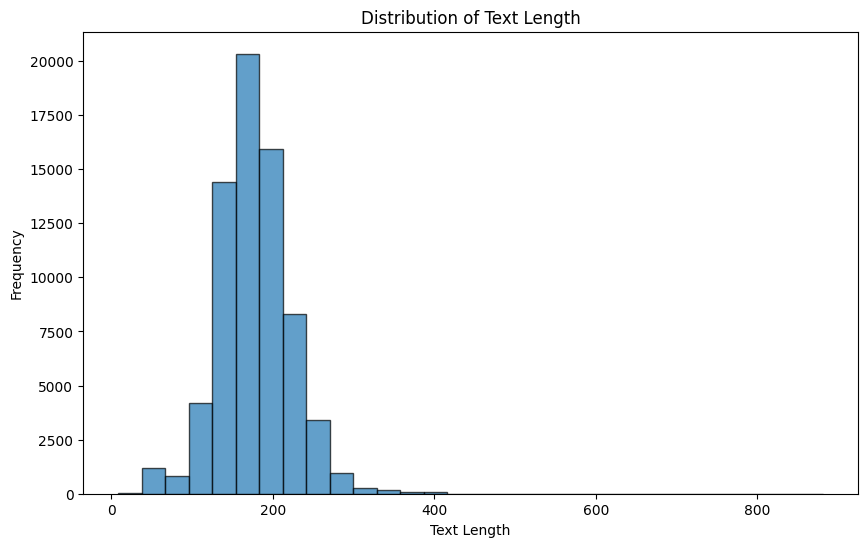

In [5]:
import matplotlib.pyplot as plt

# Compute the length of each text
data['text_length'] = data['text'].apply(len)

# Calculate average and median text length
average_length = data['text_length'].mean()
median_length = data['text_length'].median()

print(f"Average text length: {average_length}")
print(f"Median text length: {median_length}")

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


### Post Frequency

In [34]:
# Extract unique days from the 'timestamp' column
unique_days = data['timestamp'].dt.date.unique()

# Check if all posts are from the same day
if len(unique_days) == 1:
    print(f"All posts are from the same day: {unique_days[0]}")
else:
    print("The posts span multiple days. Here are the unique days:")
    print(unique_days)


All posts are from the same day: 2024-10-31


In [35]:
import matplotlib.pyplot as plt

# Ensure 'timestamp' is in datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Calculate overall post count
total_posts = data.shape[0]
print(f"Total number of posts: {total_posts}")


Total number of posts: 70260


No temporal analysis over multiple days, months or years can be performed because all posts are from 31st October 2024.

### Topic Modelling

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

# Define a function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Preprocess the text column
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Convert the text data into a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(data['cleaned_text'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Specify number of topics (n_components)
lda.fit(doc_term_matrix)

# Get the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[-num_top_words:]]))

# Display topics
num_top_words = 10  # Number of top words to display per topic
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, num_top_words)

[nltk_data] Downloading package stopwords to /Users/leori/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0:
dont, miss, low, new, high, join, climate, check, science, business
Topic 1:
support, army, love, voting, social, btsbbmas, artist, lets, vote, yhawkins
Topic 2:
people, new, real, political, energy, climate, time, change, like, politics
Topic 3:
success, looking, dont, need, politics, help, like, hey, check, business
Topic 4:
check, time, important, support, crucial, care, lets, healthcare, mental, health


In [9]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Prepare data for LDA (as a bag of words)
texts = data['text'].apply(lambda x: x.split()).tolist()  # Split text into tokens
dictionary = Dictionary(texts)  # Create a Gensim dictionary
corpus = [dictionary.doc2bow(text) for text in texts]  # Create a bag-of-words corpus

# Train LDA model using Gensim
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)

# Visualize topics using pyLDAvis
lda_visualization = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(lda_visualization)  # For Jupyter Notebooks

### Sentiment Analysis

sentiment
positive    47164
negative    14464
neutral      8632
Name: count, dtype: int64


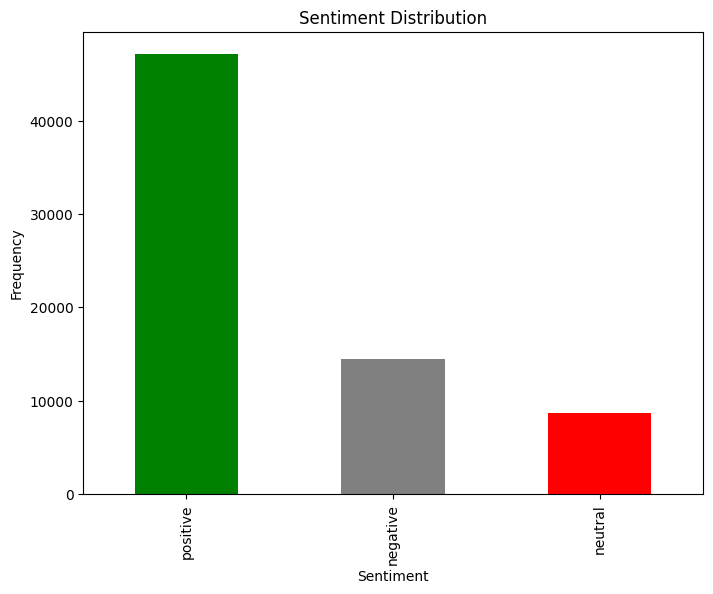

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment
def analyze_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    # Determine sentiment as positive, neutral, or negative
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the 'text' column
data['sentiment'] = data['text'].apply(analyze_sentiment)

# Output the distribution of sentiments
print(data['sentiment'].value_counts())

# Visualize sentiment distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
data['sentiment'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

In [13]:
from textblob import TextBlob

def analyze_sentiment_textblob(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['text'].apply(analyze_sentiment_textblob)
